# Gaussian Mixture Model
A Gaussian Mixture Model is a probability model that describes the probability of data using a mixture of gaussian distributions. Given a fixed parameter $K$ denoting the number of gaussian distrbutions in the mixture the probability of a point $x$ is given by:
\begin{equation}
    P(x; \pi, \mu, \Sigma) = \sum_{i=1}^{K} \pi_i \mathcal{N}(x|\mu_i, \Sigma_i)
\end{equation}

It can be seen that a Gaussian Mixture Model (GMM) is parameterised by the following parameters:
1. $\pi$: $\pi_i$ denotes the prior probability of a given point $x$ belonging to $i^{th}$ gaussian component
2. $\mu$: $\mu_i$ denotes the mean for the $i^{th}$ gaussian component
3. $\Sigma$: $\Sigma_i$ denotes the covariance matrix for the $i^{th}$ gaussian component

It is easy to see that $P(x)$ is indeed a valid probability density function. To generate a data point from this distribution we first sample a variable $z \sim \pi$. If the sampled variable $z = k$ then the point $x$ is generated by sampling from $\mathcal{N}(\mu_k, \Sigma_k)$

GMMs can also be interpretted as latent variable models. The observed data is $x$ and the associated latent variable is $z$ which denotes the component of the mixture which has generated $x$. More precisely, the following equations govern the data:

\begin{align}
    P(z = k) &= \pi_k \\
    P(x|z = k) &= \mathcal{N}(x|\mu_k, \Sigma_k) \\
\end{align}

### Generating Samples from GMMs
As described earlier, generating a sample from a GMM can be viewed as a two step process.
1. Sample $z \sim \pi$, to decide the mixture component to which $x$ must belong
2. Let the sampled value of $z$ in first step be $k$. Sample $x \sim \mathcal{N}(x|\mu_k, \Sigma_k)$.

The file `gm_generate.py` contains the code to generate samples from a GMM. Here we will use `gm_generate.py` to generate $100$ data samples from a GMM with $K=3$. All the generated $x_i \in \mathbb{R}^2$. We then plot these points using different colors for different values of $z$.

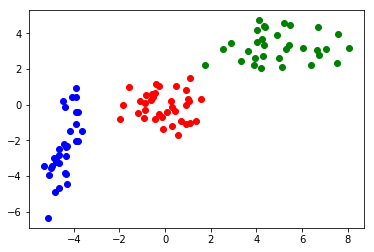

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gm_generate import *

# Initialize P(z=k) for all k (pi)
pz = [1.0/3]*3 # Using uniform distribution

# Initialize the means mu_k
mu_1 = np.asarray([0.0, 0.0])
mu_2 = np.asarray([5.0, 3.0])
mu_3 = np.asarray([-4.5, -3.0])
mu = [mu_1, mu_2, mu_3]

# Initialize the covariance sigma_k
sigma_1 = np.asarray([[1.0, 0.0], [0.0, 1.0]])
sigma_2 = np.asarray([[3.0, 0.0], [0.0, 1.0]])
sigma_3 = np.asarray([[0.5, 2.0], [0.5, 3.0]])
sigma = [sigma_1, sigma_2, sigma_3]

# Get the GMM object
gmm = GMM(pz=pz, muks=mu, sigmaks=sigma, k=3, d=2)

# Generate 100 data points
(x, z) = gmm.generate_points(n=100)

# Plot the data
idx_1 = np.where(z == 0) # Indices for first cluster
plt.plot(x[idx_1, 0], x[idx_1, 1], 'ro')
idx_2 = np.where(z == 1) # Indices for second cluster
plt.plot(x[idx_2, 0], x[idx_2, 1], 'go')
idx_3 = np.where(z == 2) # Indices for third cluster
plt.plot(x[idx_3, 0], x[idx_3, 1], 'bo')
plt.show()

Note that `gm_generate.py` can also be used to sample from a single gaussian distribution. Just set the value of $K$ to $1$. The following code uses `gm_generate.py` to generate $1000$ data points drawn from a 1-D gaussian distribution.

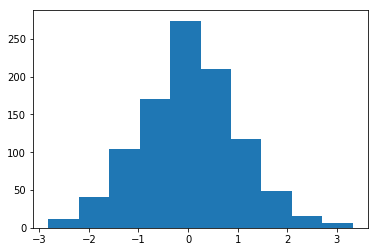

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gm_generate import *

# Initlialize P(z=k) for all k, here k can take only 1 value
pz = [1.0]

# Initialize mu and sigma for the distribution
mu = [np.asarray([0.0])]
sigma = [np.asarray([1]).reshape((1, 1))]

# Get the GMM object
gmm = GMM(pz=pz, muks=mu, sigmaks=sigma, k=1, d=1)

# Generate 1000 data points
x, _ = gmm.generate_points(n=1000)

# Show the histogram
plt.hist(x)
plt.show()

# Probabilistic Inference

Often we have more than one random variables which interact with each other in complicated ways. At any given time we can observe the value of some of these random variables. We call these _observed_ random variables. There are other random variables whose value we can not observe. These are called _unobserved_ random variables. Inference deals with finding a probability distribution over one or more _unobserved_ variables given the values of all _observed_ variables.


In the context of GMMs we observe the data points $x_i$'s and usually the aim is to infer the value of corresponding latent variable $z_i$'s. Using Bayes' Rule we can calculate:

\begin{equation}
    P(z|x) = \frac{P(x|z)P(z)}{P(x)}
\end{equation}

The denominator term can be calculated using the total probability theorem as $P(x) = \sum_{z} P(x|z)P(z)$. The summation is over all possible values of $z$. Note that in the particular case of GMMs, the data points are drawn iid and $z$ is a discrete random variable that takes $K$ distinct values, hence this summation is easy to calculate. In general, however, calculating $P(x)$ is an intractible problem. Thus exact inference is intractible in general and that is why we need to resort to approximation methods. Variational Inference is one such method.

# Variational Inference
The objective is to approximate the posterior $p(z|x)$. Variational Inference turns the problem of inference into an optimization problem. Let $\mathcal{D}$ be a parameteric family of distribution, then we find a distribution $q^*(z) \in \mathcal{D}$ as:

\begin{equation}
    q^*(z) = arg\min_{q(z) \in \mathcal{D}} KL(q(z) || p(z|x))
\end{equation}

$q^*(z) \in \mathcal{D}$ serves as an approximation to the true posterior $p(z|x)$. In the equation above KL-divergence has been used as a measure for calculating the degree of _"closeness"_ between the distributions $q$ and $p$. This is the most common choice although it is not the only choice.

\begin{align}
    KL(q(z) || p(z|x)) &= \mathbb{E}_{z \sim q(z)} \big[\log q(z) - \log p(z|x)\big] \\
    &= \mathbb{E}_{z \sim q(z)} \big[\log q(z) - \log p(x,z) + \log p(x)\big] \\
    &= \mathbb{E}_{z \sim q(z)} \big[\log q(z) - \log p(x,z)\big] + \log p(x)
\end{align}

Note that the calculation of $KL(q||p)$ involves the calculation of $p(x)$ which as we noted earlier is intractible. Hence calculating the exact value for $KL(q||p)$ is intractible. However since we wish to minimize $KL(q||p)$ one can resort to minimizing an upper bound on $KL(q||p)$. Note that since $\log p(x)$ will always be negative the following inequality follows from the previous equation:

\begin{equation}
    KL(q(z) || p(z|x)) \leq \mathbb{E}_{z \sim q(z)} \big[\log q(z) - \log p(x,z)\big]
\end{equation}

For most models that are used in practice the term $p(x, z)$ is easy to calculate.

### Evidence Lower Bound Objective (ELBO)
The negative of the quantity on the right hand side of the previous equation is known as ELBO.

\begin{equation}
    ELBO(q) = \mathbb{E}_{z \sim q(z)} \big[\log p(x,z) - \log q(z)\big]
\end{equation}

The following statements are easy to prove:
1. $ELBO(q) \leq \log p(x)$, that is why it is called the evidence lower bound
2. Maximizing ELBO is equivalent to minimizing an upper bound on $KL(q||p)$
3. Maximizing ELBO is also equivalent to maximizing $\log p(x)$

### Choosing $\mathcal{D}$
In order to completely specify the optimization problem one final thing that we need is a specification for $\mathcal{D}$. The complexity of $\mathcal{D}$ determines the overall complexity of the optimization problem. In general $\mathcal{D}$ is chosen such that:
1. $\mathcal{D}$ is expressive enough to approximate the posterior $p(z|x)$ but simple enough to make the optimization problem tractable
2. It must be easy to calculate the expectation term in the objective function

For example one can set $\mathcal{D} = \{\mathcal{N}(\mu, \Sigma)\,\,:\,\, \mu \in \mathbb{R}^d, \Sigma \in \mathbb{R}^{d \times d}\}$. $\mathcal{D}$ is a parametric family of normal distribution and the parameters are $\mu$ and $\Sigma$.

The optimization problem is:
\begin{equation}
    q^*(z) = arg\max_{q(z) \sim \mathcal{D}} ELBO(q)
\end{equation}

# Toy Example 1 - Gaussian Distribution
We begin our exploration of Variational Inference with a very simple problem. We are given a set of $N$ real numbers $x_1, x_2, ..., x_N$ and the task is to fit a gaussian distribution $\mathcal{N}(\mu, \sigma^2)$ to this data. This can be very easily done by using Maximum Likelihood Estimation to compute point estimates for parameters $\mu$ and $\sigma^2$. Another approach is to pose this problem into the Variational Inference framework to get an approximation for the unknown distribution. We implement both these approaches.

### Using Maximum Likelihood Estimation
Assuming that the data points are drawn iid from a gaussian distrubution $\mathcal{N}(\mu, \sigma^2)$, the log probability of data is given by:

\begin{align}
    \mathcal{L}(x, \mu, \sigma^2) &= \log P(x; \mu, \sigma^2) \\
    &= \sum_{i=1}^{N} \log \mathcal{N}(x_i| \mu, \sigma^2) \\
    &= \sum_{i=1}^{N} \big(-\frac{1}{2}\log 2\pi - \frac{1}{2}\log \sigma^2 - \frac{(x_i - \mu)^2}{2\sigma^2}\big)
\end{align}

Under Maximum Likelihood Estimation we maximize $\mathcal{L}(x, \mu, \sigma^2)$ with respect to the paramters $\mu$ and $\sigma^2$. Taking the gradient of $\mathcal{L}$ with respect to the parameters and equating it to zero we get the following equations:

\begin{align}
    \frac{\partial \mathcal{L}}{\partial \mu} = 0 &\Rightarrow \mu = \frac{1}{N} \sum_{i=1}^{N} x_i \\
    \frac{\partial \mathcal{L}}{\partial \sigma^2} = 0 &\Rightarrow \sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 
\end{align}

The following code first generates $100$ data points from a gaussian distrubution $\mathcal{N}(0, 1)$ using `gm_generate.py` and then fits a gaussian distribution to the data using Maximum Likelihood Estimation as described above.

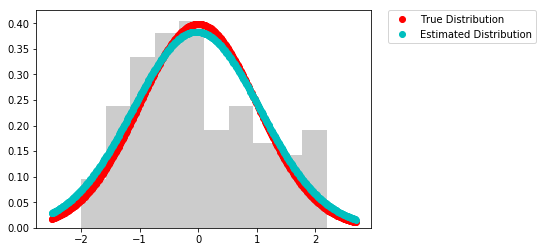

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gm_generate import *

# Generate the data
pz = [1.0]
mu = [np.asarray([0.0])]
sigma = [np.asarray([1]).reshape((1, 1))]
gmm = GMM(pz=pz, muks=mu, sigmaks=sigma, k=1, d=1)
x, _ = gmm.generate_points(n=100)

# Compute maximum likelihood estimation for the parameters
mu_mle = np.mean(x) # mu_mle = sample mean
sigma_mle = np.var(x) # sigma_mle = sample variance

# Show the histogram, true distribution and estimated distribution
plt.hist(x, normed=True, color='#cccccc')
def true_dist(x):
    return (1.0/np.sqrt(2*np.pi*sigma[0])*np.exp(-0.5*((x-mu[0])/sigma[0])**2))
def estimated_dist(x):
    return (1.0/np.sqrt(2*np.pi*sigma_mle)*np.exp(-0.5*((x-mu_mle)/sigma_mle)**2))
x_axis = np.arange(np.min(x)-0.5, np.max(x)+0.5, 0.01)
plt.plot(x_axis, true_dist(x_axis).reshape((-1,)), 'ro', label='True Distribution')
plt.plot(x_axis, estimated_dist(x_axis).reshape((-1,)), 'co', label='Estimated Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Using Variational Inference
We now pose this problem in the Variational Inference framework. $\mu$ and $\sigma^2$ will be treated as random variables and we are interested in finding the posterior distribution $P(\mu, \sigma^2 | X)$, where $X = \{x_1, ..., x_N\}$. As described earlier, we approximate $P(\mu, \sigma^2 | X)$ by a parametric distribution $q(\mu, \sigma^2)$. Further we assume that $q(\mu, \sigma^2)$ can be factorised into $q_1(\mu)q_2(\sigma^2)$. This assumption is known as the mean-field assumption and it will be discussed in detail later on. The first step is to write a parametric form for $q_1(\mu)$ and $q_2(\sigma^2)$. We assign the following parametric forms:

\begin{align}
    q_1(\mu) &= \mathcal{N}(\mu|m, s^2) \\
    q_2(\sigma^2) &= Gamma(\alpha, \beta)
\end{align}

The parameters $m$, $s^2$, $\alpha$ and $\beta$ are called Variational Parameters and they will be determined by using the available data $X$. We also need a prior distribution over $\mu$ and $\sigma^2$ in order to calculate the joint distribution $P(x, \mu, \sigma^2)$. The prior reflects our knowledge about the domain of the problem. This is the step where subject experts can step in and help in proper modelling of the problem. We use the following priors:

\begin{align}
    p(\mu) &= \mathcal{N}(\mu|m_p, s_p^2) \\
    p(\sigma^2) &= Gamma(\alpha_p, \beta_p)
\end{align}

The parameters $m_p$, $s_p^2$, $\alpha_p$ and $\beta_p$ are the hyperparameters that will be provided by the user. Now we are ready to calculate the ELBO.

\begin{align}
    ELBO(q) &= \mathbb{E}_{\mu, \sigma^2 \sim q}\big[\log p(X, \mu, \sigma^2) - \log q(\mu, \sigma^2)\big] \\
    &= \mathbb{E}_{\mu, \sigma^2 \sim q}\big[\log p(X | \mu, \sigma^2)p(\mu)p(\sigma^2) - \log q_1(\mu)q_2(\sigma^2)\big] \\
    &= \mathbb{E}_{\mu, \sigma^2 \sim q}\big[\log p(X | \mu, \sigma^2) + \log p(\mu) + \log p(\sigma^2) - \log q_1(\mu) - \log q_2(\sigma^2)\big] \\
    &= \mathbb{E}_{\mu, \sigma^2 \sim q}\big[\sum_{i=1}^{N}\log p(x_i | \mu, \sigma^2) + \log p(\mu) + \log p(\sigma^2) - \log q_1(\mu) - \log q_2(\sigma^2)\big] \\
    &= K + \mathbb{E}_{\mu, \sigma^2 \sim q}\big[\sum_{i=1}^{N}\big(-\frac{\log \sigma^2}{2} - \frac{(x_i-\mu)^2}{2\sigma^2}\big) -\frac{(\mu-m_p)^2}{2s_p^2} + (\alpha_p - 1)\log \sigma^2 - \frac{\sigma^2}{\beta_p}\big] - \mathbb{E}_{\mu \sim q_1}\big[\log q_1(\mu)\big] - \mathbb{E}_{\sigma^2 \sim q_2}\big[\log q_2(\sigma^2)\big] \\
    &= K + \mathbb{E}_{\mu, \sigma^2 \sim q}\big[\sum_{i=1}^{N}\big(-\frac{\log \sigma^2}{2} - \frac{(x_i-\mu)^2}{2\sigma^2}\big) -\frac{(\mu-m_p)^2}{2s_p^2} + (\alpha_p - 1)\log \sigma^2 - \frac{\sigma^2}{\beta_p}\big] + \mathcal{H}(q_1) + \mathcal{H}(q_2) \\
    &= K + \mathbb{E}_{\mu, \sigma^2 \sim q}\big[-\frac{N \log \sigma^2}{2} - \sum_{i=1}^{N}\frac{(x_i-\mu)^2}{2\sigma^2} -\frac{N(\mu-m_p)^2}{2s_p^2} + (\alpha_p - 1)\log \sigma^2 - \frac{\sigma^2}{\beta_p}\big] + \mathcal{H}(q_1) + \mathcal{H}(q_2) \\
    &= K + \frac{\Gamma(\alpha-1)}{\beta\Gamma(\alpha)}\big(m\sum_{i=1}^{N} x_i - \frac{N}{2}(m^2 + s^2) - \frac{1}{2}\sum_{i=1}^{N} x_i^2\big) + (\alpha_p - \frac{N}{2})(\psi(\alpha) + \log \beta) - \frac{\alpha\beta}{\beta_p} + \alpha + \log \Gamma(\alpha) -\alpha\psi(\alpha) + \frac{\log 2s^2\pi e}{2}
\end{align}

Here we have used the following results:
1. $\mathcal{H}(q_1) = \frac{1}{2} \log 2\sigma^2\pi e$
2. $\mathcal{H}(q_2) = \alpha + \log \beta + \log \Gamma(\alpha) + (1-\alpha)\psi(\alpha)$
3. $q(\mu, \sigma^2) = q_1(\mu)q_2(\sigma^2)$

The function $\psi(\alpha)$ is called Digamma function. $\psi(\alpha) = \frac{\Gamma'(\alpha)}{\Gamma(\alpha)}$. $K$ contains all the terms which are independent of variational parameters (and hence can be ignored while optimizing ELBO). The given expression for ELBO is maximized with respect to the variational parameters $\alpha$, $\beta$, $m$ and $s^2$. Unfortunately a closed form solution for optimal variational parameters does not exist in this case, although we can used gradient based techniques for finding them.

We now turn to implementation where we use TensorFlow to maximize the ELBO. The file `toy_example_1.py` contains the function `train_step()` that takes as input the data $X$ and performs one iteration of update to the variational parameters. As before $100$ data points are generated using `gm_generate.py` and the data is used to find the optimal variational parameters using `toy_example_1.py`.

Optimal m: 0.0223558
Optimal s^2: 0.0101681906669
Optimal alpha: 14.7924620757
Optimal beta: 0.0737221009091
Expected Value for mu: 0.0223558
Optimal Value for sigma^2: 1.09053138184


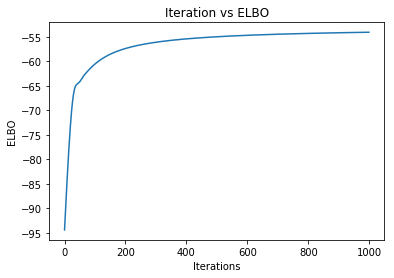

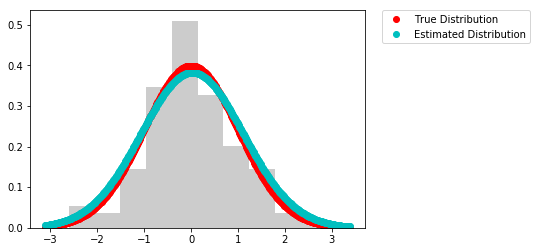

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gm_generate import *
from toy_example_1 import *

# Generate the data
pz = [1]
mu = [np.asarray([0.0])]
sigma = [np.asarray([1]).reshape((1, 1))]
gmm = GMM(pz=pz, muks=mu, sigmaks=sigma, k=1, d=1)
x, _ = gmm.generate_points(n=100)
x = x.reshape((-1,))

# Hyperparameter
mu_p=0.0
sigma_p=1.0
alpha_p=3.5
beta_p=0.5
learning_rate=1e-2

# Compute variational inference estimate for the parameters
costs = []
toy_example = ToyExample1(mu_p, sigma_p, alpha_p, beta_p, learning_rate)
for i in range(1000):
    cost, mu_ex, sigma_ex, alpha, beta = toy_example.train_step(x)
    costs.append(cost)

# Compute mu_expected, sigma_expected
mu_expected = mu_ex # Expected value of mu using q_1 (normal)
sigma_expected = beta*alpha # Expected value of sigma using q_2 (gamma)

# Print results
print 'Optimal m:', mu_ex
print 'Optimal s^2:', sigma_ex
print 'Optimal alpha:', alpha
print 'Optimal beta:', beta
print 'Expected Value for mu:', mu_expected
print 'Optimal Value for sigma^2:', sigma_expected
    
# Plot cost vs iterations
plt.plot(costs)
plt.title('Iteration vs ELBO')
plt.xlabel('Iterations')
plt.ylabel('ELBO')
plt.show()

# Show the histogram, true distribution and estimated distribution
plt.hist(x, normed=True, color='#cccccc')
def true_dist(x):
   return (1.0/np.sqrt(2*np.pi*sigma[0])*np.exp(-0.5*((x-mu[0])/sigma[0])**2))
def estimated_dist(x):
    return (1.0/np.sqrt(2*np.pi*sigma_expected)*np.exp(-0.5*((x-mu_expected)/sigma_expected)**2))
x_axis = np.arange(np.min(x)-0.5, np.max(x)+0.5, 0.01)
plt.plot(x_axis, true_dist(x_axis).reshape((-1,)), 'ro', label='True Distribution')
plt.plot(x_axis, estimated_dist(x_axis).reshape((-1,)), 'co', label='Estimated Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Note that unlike Maximum Likelihood Estimation, Variational Inference does not return point estimates for $\mu$ and $\sigma^2$. In this case we get the distributions describing $\mu$ and $\sigma^2$ which are $\mathcal{N}(m, s^2)$ and $Gamma(\alpha, \beta)$ respectively. In order to get a single value for $\mu$ and $\sigma^2$ we find the expected values of these variables under their respective distributions. The plot shows that these expected values are indeed very close to the ground truth values.

Another important issue involved here is the choice of hyperparameters. One has to select the prior carefully, although in the prescence of a lot of data - as it is commonly said - data overwhelms prior. Hence if we have a lot of data, the choice of hyperparameters do not significantly affect the final results. Next we demonstrate this. To avoid clutter we will call function `run_toy_example_1()` from `toy_example_1.py` which contains exactly the same code as the previous demo.

Optimal m: 9.83141
Optimal s^2: 4.75094301673
Optimal alpha: 6.93314044937
Optimal beta: 8.00713458598
Expected Value for mu: 9.83141
Optimal Value for sigma^2: 55.5145886816


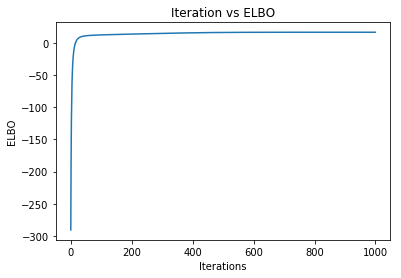

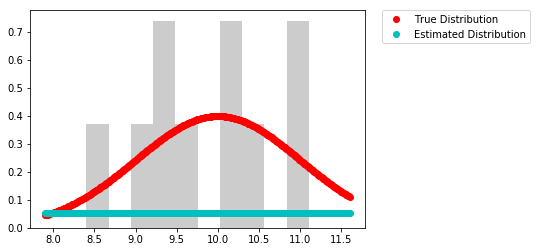

In [25]:
# Variational Inference with a bad prior using only 10 examples
from toy_example_1 import *

data_mean = 10.0
data_variance = 1.0
num_examples = 10
num_iters = 1000

# Hyperparameters
mu_p = -1.0 # Prior is peaked at mu = -1 but true mean is mu = 10
sigma_p = 1.0
alpha_p = 10 # The optimal value will be close to 4
beta_p = 10 # The optimal value will be close to 0
learning_rate=1e-1

# Run the demo
run_toy_example_1(num_examples, data_mean, data_variance, mu_p, sigma_p, alpha_p, beta_p, learning_rate, num_iters)

It can be seen that when only 10 examples were used, although the mean was estimated properly, the biased prior for variance lead to incorrect estimation for variance. However, if we use 100 examples, even with the biased prior we get approximately the correct results.

Optimal m: 10.1042
Optimal s^2: 0.0132560920497
Optimal alpha: 11.7797199472
Optimal beta: 0.122972674671
Expected Value for mu: 10.1042
Optimal Value for sigma^2: 1.44858366877


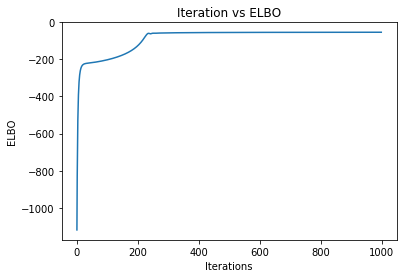

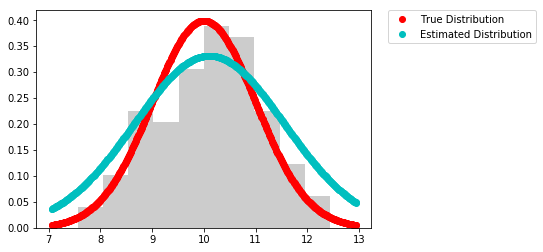

In [26]:
# Variational Inference with a bad prior using only 10 examples
from toy_example_1 import *

data_mean = 10.0
data_variance = 1.0
num_examples = 100
num_iters = 1000

# Hyperparameters
mu_p = -1.0 # Prior is peaked at mu = -1 but true mean is mu = 10
sigma_p = 1.0
alpha_p = 10 # The optimal value will be close to 4
beta_p = 10 # The optimal value will be close to 0
learning_rate=1e-1

# Run the demo
run_toy_example_1(num_examples, data_mean, data_variance, mu_p, sigma_p, alpha_p, beta_p, learning_rate, num_iters)

Using Variational Inference for such a simple example was an overkill. It might seem that Variational Inference is very complicated as compared to Maximum Likelihood Estimation. On this particular example it actually is a lot more complicated without giving any apparent improvement in performance. However in general when distributions become very complex, Variational Inference is the way to go. We will demonstrate this using more complex examples in the upcoming sections.